<a href="https://colab.research.google.com/github/ucestth/CECG0004_CHAOS/blob/Siwei/LeNet_reproduction_Chaos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras

To build our model we need to do a few steps:
- Download the MNIST dataset with consist of labeled handwritten images (28x28 px).
- Identify the feature that we are going to train the model on, which are just our image pixels.
- And let us use neural networks to build our model (LeNet-5 network architecture).
- The final step would to train our model and then test and validate how well we did.


## 1. Download MNIST dataset

Four files are available on this site, http://yann.lecun.com/exdb/mnist/:

* train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
* t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
* t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

In [1]:
from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [2]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

## Load the data

Load train and test data in memory

In [3]:
# Update libraries
!pip install seaborn==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [4]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)

    return features, labels

In [6]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

### Explore the data

It is always a good to do some data exploration before we start using it, find outliers, and decide if we need a preprocessing phase to uniform or augment it. And also to make sure that all the classes are covered by or more or less the same number of samples.


In [7]:
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# of training images: 60000
# of test images: 10000


#### Display some images

In [8]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

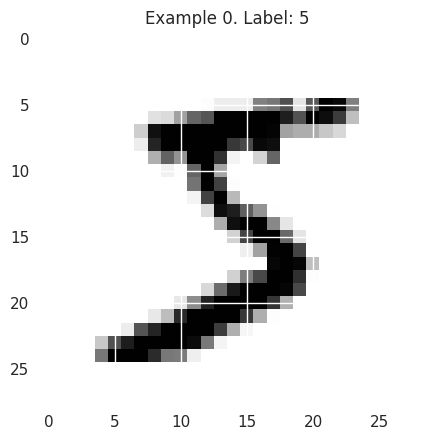

In [9]:
display_image(0)

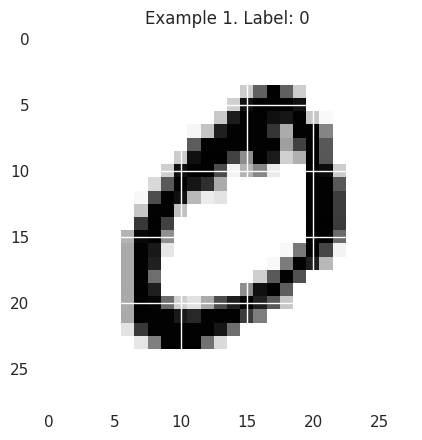

In [10]:
display_image(1)

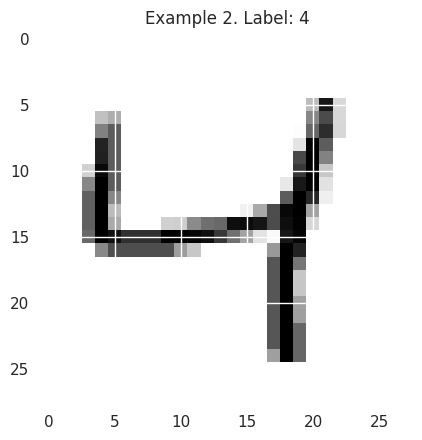

In [ ]:
display_image(2)

#### Plot training data

In [11]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


### Split training data into training and validation

In [12]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [13]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


## 2. Prepare our input features

The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [14]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')

print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


## 3. LeNet-5 implmentation

![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
>>> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)



**The following part is heavily inspired by** https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

#### Input
    32x32x1 pixels image

#### Architecture
* **Convolutional #1** outputs 28x28x6
    * **Activation** any activation function, we will `relu`

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** any activation function, we will `relu`

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** any activation function, we will `relu`

* **Fully Connected #2** outputs 84
    * **Activation** any activation function, we will `relu`

* **Fully Connected (Logits) #3** outpute 10


In [53]:
from keras.layers import Activation
from keras import backend as K
from keras.utils import get_custom_objects

## Page 8 Section B and Appendix A: custom squash/activation function used in the LeNet-5 was f(a) = A*tanh(S*a) where A = 1.1759 and S = 2/3
def custom_activation(x):
    return (K.tanh(2/3 * x) * 1.7159)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})


In [54]:
## page10 section IIIB: Global learning rate was scheduled as: 0.0005 for the first two passes; 0.0002 for the next three; 0.0001 for the next three; 0.000 05 for the next 4; and 0.000 01 thereafter.

from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 2:
        return 0.0005
    elif epoch < 5:
        return 0.0002
    elif epoch < 8:
        return 0.0001
    elif epoch < 12:
        return 0.00005
    else:
        return 0.00001

callback = LearningRateScheduler(lr_schedule)



In [17]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (Average  (None, 15, 15, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [20]:
EPOCHS = 10
BATCH_SIZE = 128

In [21]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [22]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_generator, validation_steps=validation_steps,
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000


<ipython-input-22-319f01e6f6d5>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,


Epoch 1/10
375/375 [==============================] - 8s 9ms/step - loss: 0.3250 - accuracy: 0.9220 - val_loss: 0.0986 - val_accuracy: 0.9692
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0773 - accuracy: 0.9766 - val_loss: 0.0684 - val_accuracy: 0.9799
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0516 - accuracy: 0.9837 - val_loss: 0.0903 - val_accuracy: 0.9735
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0409 - accuracy: 0.9871 - val_loss: 0.0566 - val_accuracy: 0.9843
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0320 - accuracy: 0.9900 - val_loss: 0.0569 - val_accuracy: 0.9838
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0264 - accuracy: 0.9916 - val_loss: 0.0559 - val_accuracy: 0.9839
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.0513 - val_accuracy: 0.9861
Epoc

In [23]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0512 - accuracy: 0.9871
Test loss: 0.05121209844946861
Test accuracy: 0.9871000051498413


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


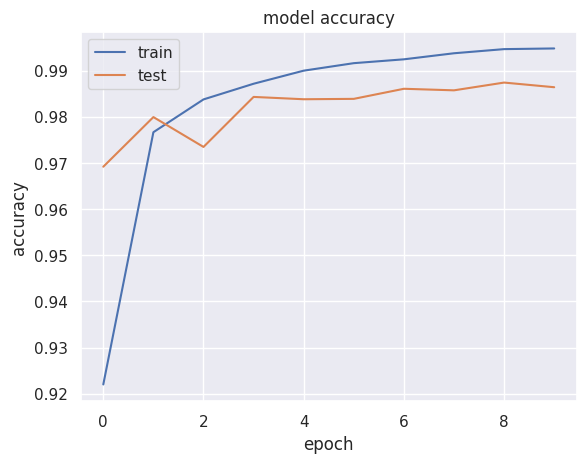

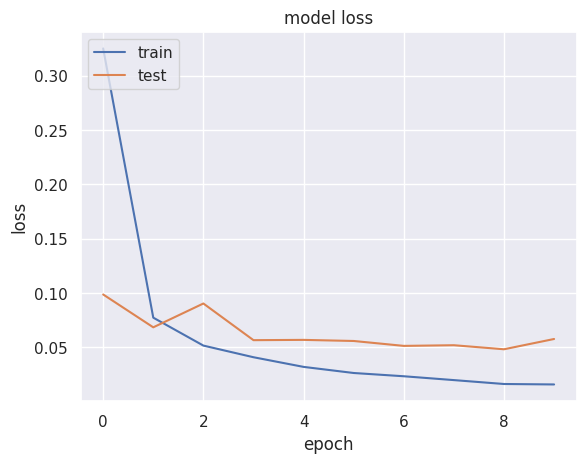

In [24]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

LOG_DIR = 'logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

--2024-02-14 16:59:16--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  6.56MB/s    in 2.0s    

2024-02-14 16:59:19 (6.56 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [26]:
mat = model.predict(test['features'])

313/313 [==============================] - 1s 2ms/step


In [27]:
y_pred = np.argmax(mat,axis=1)

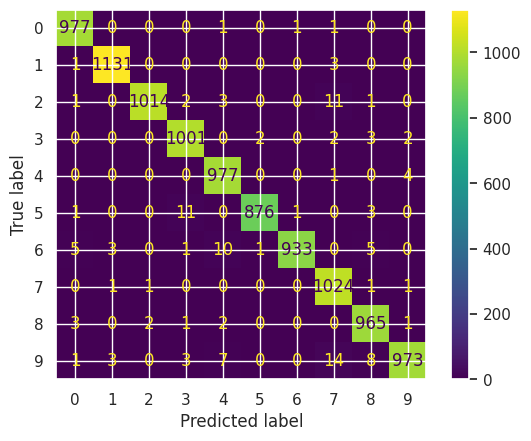

In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay

conf_mat = confusion_matrix(test['labels'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()

plt.show()

In [36]:
precision = precision_score(test['labels'],y_pred, average = 'micro')
recall= recall_score(test['labels'],y_pred, average = 'micro')
f1 = f1_score(test['labels'],y_pred, average = 'micro')

print('Precision =', precision, 'Recall = ',recall, 'F1-score =',f1)

Precision = 0.9871 Recall =  0.9871 F1-score = 0.9871


In [37]:
ngrok_url = !curl -s http://localhost:4040/api/tunnels | python -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

ngrok_url = ngrok_url[0].replace("'", '')
print(ngrok_url)

Traceback (most recent call last):


In [38]:
from IPython.display import IFrame

IFrame(ngrok_url, width=700, height=900)

In [90]:
## Model_1 faithfully recreates the original conditions under which LeNet-5 was created: custom tanh activation function, scheduled learning rate, same model architecture.

model_1 = keras.Sequential()

model_1.add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1,1), activation=custom_activation, input_shape=(32,32,1), padding='valid'))
model_1.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

model_1.add(layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1,1), activation=custom_activation, input_shape=(32,32,1), padding='valid'))
model_1.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

model_1.add(layers.Flatten())

model_1.add(layers.Dense(units=120, activation=custom_activation))

model_1.add(layers.Dense(units=84,activation=custom_activation))

model_1.add(layers.Dense(units=10, activation = 'softmax'))

In [91]:
model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [92]:
EPOCHS_1 = 20
BATCH_SIZE_1 = 128

In [100]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch_1 = X_train.shape[0]//BATCH_SIZE_1
validation_steps_1 = X_validation.shape[0]//BATCH_SIZE_1

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history_1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch_1, epochs=EPOCHS_1,
                    validation_data=validation_generator, validation_steps=validation_steps_1,
                    shuffle=True, callbacks=[callback])

# of training images: 48000
# of validation images: 12000
Epoch 1/20
  1/375 [..............................] - ETA: 19s - loss: 0.0026 - accuracy: 1.0000

<ipython-input-100-f885cbd94560>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch_1, epochs=EPOCHS_1,


375/375 [==============================] - 5s 13ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0363 - val_accuracy: 0.9912 - lr: 5.0000e-04
Epoch 2/20
375/375 [==============================] - 6s 16ms/step - loss: 7.3905e-04 - accuracy: 0.9999 - val_loss: 0.0376 - val_accuracy: 0.9908 - lr: 5.0000e-04
Epoch 3/20
375/375 [==============================] - 5s 12ms/step - loss: 5.0345e-04 - accuracy: 1.0000 - val_loss: 0.0358 - val_accuracy: 0.9919 - lr: 2.0000e-04
Epoch 4/20
375/375 [==============================] - 5s 14ms/step - loss: 4.3975e-04 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 0.9919 - lr: 2.0000e-04
Epoch 5/20
375/375 [==============================] - 3s 9ms/step - loss: 4.0984e-04 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 0.9918 - lr: 2.0000e-04
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 3.6502e-04 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9916 - lr: 1.0000e-04
Epoch 7/20
375/375 [=============

In [101]:
score = model_1.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0334 - accuracy: 0.9911
Test loss: 0.033373866230249405
Test accuracy: 0.991100013256073


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


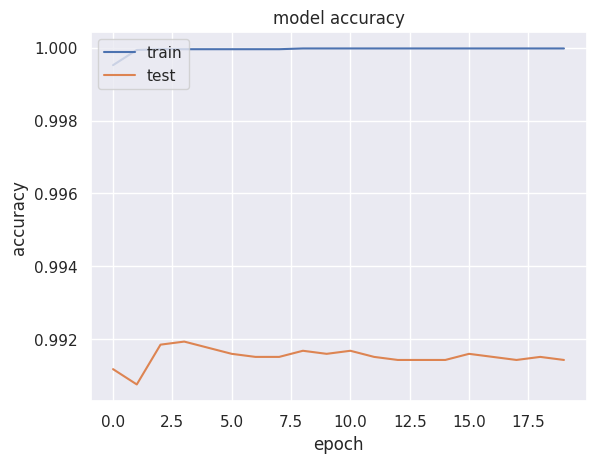

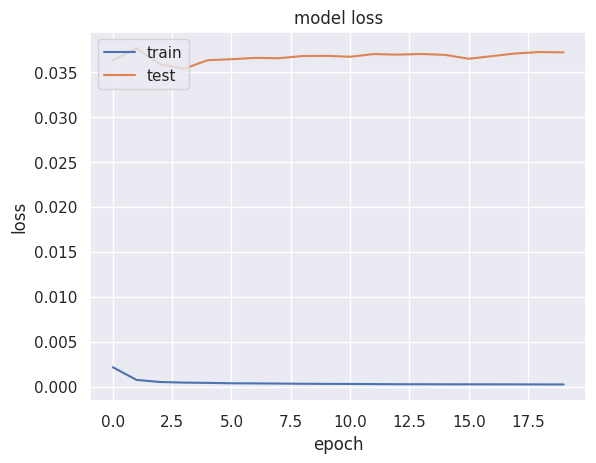

In [102]:
import matplotlib.pyplot as plt
# list all data in history
print(history_1.history.keys())
# summarize history for accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
matrix = model_1.predict(test['features'])

313/313 [==============================] - 1s 2ms/step


In [104]:
y_pred1 = np.argmax(matrix,axis=1)

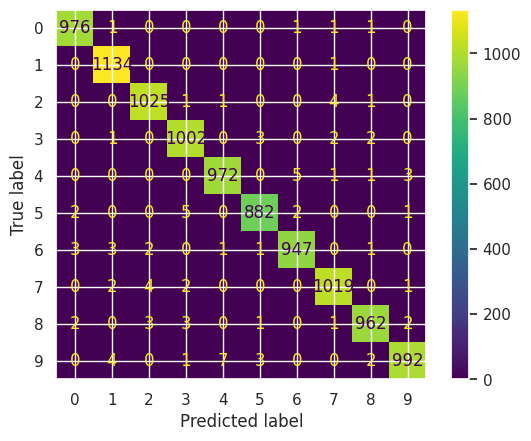

In [105]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
conf_mat1 = confusion_matrix(test['labels'], y_pred1)
display = ConfusionMatrixDisplay(confusion_matrix=conf_mat1)
display.plot()

plt.show()

In [106]:
precision1 = precision_score(test['labels'],y_pred1, average = 'micro')
recall1= recall_score(test['labels'],y_pred1, average = 'micro')
f11 = f1_score(test['labels'],y_pred1, average = 'micro')

print('Precision =', precision1, 'Recall = ',recall1, 'F1-score =',f11)

Precision = 0.9911 Recall =  0.9911 F1-score = 0.9911
